In [1]:
%matplotlib inline
%load_ext watermark

In [2]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
import xray
#
import map_plot_func as mymap
import mypaths
import pmc_traj
import phys_meteo as met

In [3]:
%watermark -u -d -m -v -p numpy,matplotlib,iris,xray,sattools,umtools,faamtools

last updated: 2016-08-16 

CPython 3.5.2
IPython 5.0.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
xray 0.7.0
sattools 0.1
umtools 0.1.5
faamtools 0.2.3

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [4]:
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'sans-serif'

In [5]:
fmt = 'pdf'
svfigkw = dict(format=fmt, dpi=300, bbox_inches='tight')

In [6]:
sbplt_labels = list(string.ascii_lowercase)

In [7]:
plot_pl_loc = True
plot_ds = False
plot_track = False

In [8]:
lon0 = 11
lat0 = 74
mapkw = dict(lon1=lon0-21,lon2=lon0+29,lat1=lat0-8,lat2=lat0+7,tick_incr=[5.,1.],resolution='h', fill=True)

In [9]:
pmcs = pmc_traj.get_pmc_list(mypaths.trajf)
PL = pmcs[10]

In [10]:
erai_data = xray.open_dataset(mypaths.erai_plev)

In [11]:
lons, lats = np.meshgrid(erai_data.longitude.data, erai_data.latitude.data)

In [12]:
dtimes = [0, 12]
levels = [500, 850]
temp_levs = [np.arange(225,247.5,2.5), np.arange(245,267.5,2.5)]

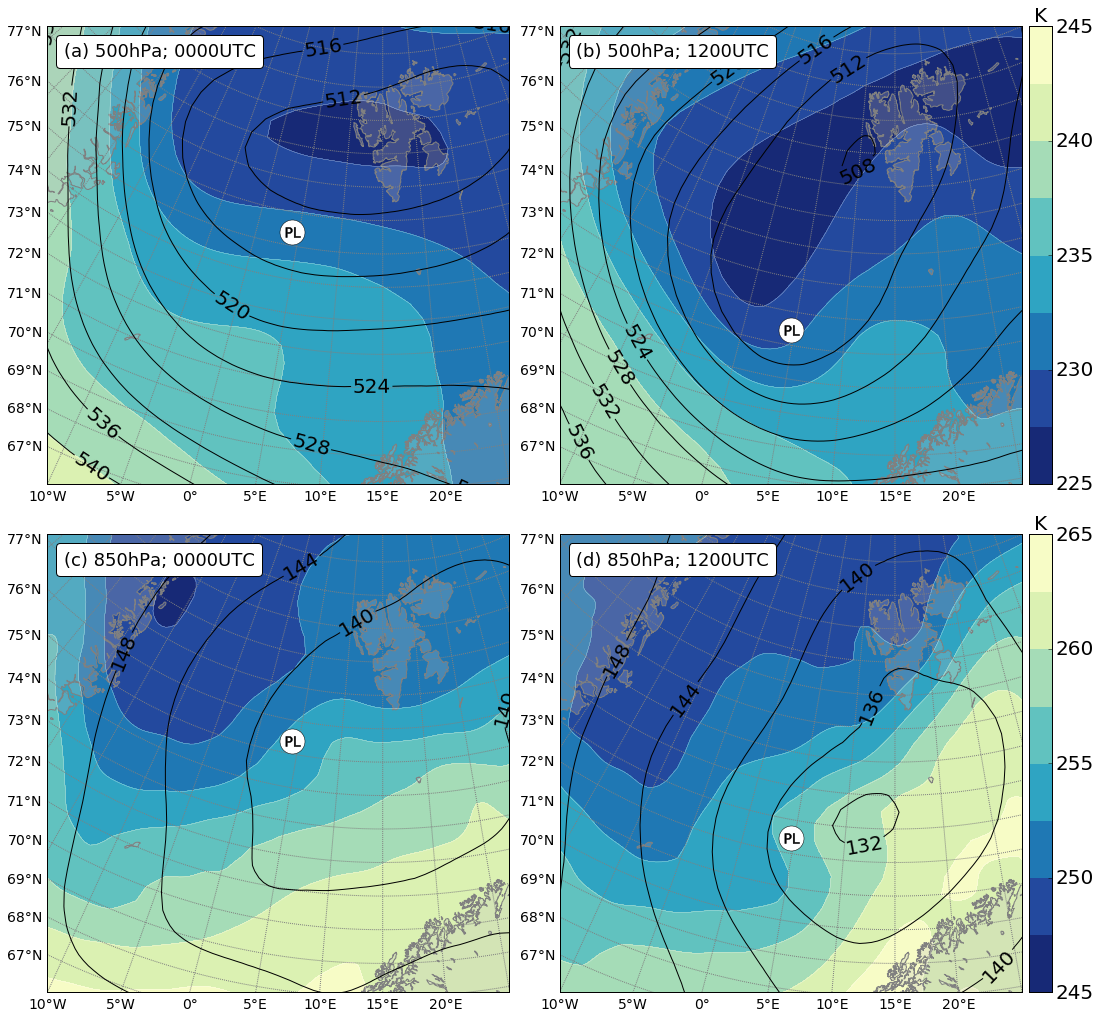

In [14]:
fig = plt.figure(figsize=(18,18))
grid = AxesGrid(fig, 111,
                    nrows_ncols=(2, 2),
                    axes_pad=0.7,
                    cbar_location='right',
                    cbar_mode='edge',
                    cbar_pad=0.1,
                    )

axs = np.array(grid.axes_all).reshape(2,2)

ii = 0
for i, (axrow, ilev, temp_lev) in enumerate(zip(axs, levels, temp_levs)):
    for n, ihour in enumerate(dtimes):
        iax = axrow[n]
        bm = mymap.make_map(ax=iax, **mapkw)
        fig.subplots_adjust(wspace=0., hspace=0.1)

        idt = datetime.datetime(2013, 3, 26, ihour)
        
        temp2d = erai_data.t.sel(time=idt, level=ilev)
        hgt2d = erai_data.z.sel(time=idt, level=ilev)

        c = bm.contourf(lons, lats, temp2d.data, temp_lev, cmap='YlGnBu_r', alpha=1, latlon=True)
        _ = bm.contour(lons, lats, temp2d.data, temp_lev, latlon=True, colors='w', linewidths=0.25)


        cc = bm.contour(lons,lats, hgt2d.data / (met.g*10), np.arange(0, 1000, 4), colors='k', latlon=True, zorder=4)
        clbls = iax.clabel(cc, inline=1, fmt='%3.0f', inline_spacing=30, fontsize=20, colors='k')

        if plot_pl_loc:
            it_traj = PL.dt.index(min(PL.dt, key=lambda date : abs(idt-date)))
            if abs((PL.dt[it_traj] - idt).total_seconds() / 3600.) < 3:
                bm.plot(PL.lon[it_traj], PL.lat[it_traj], linestyle='', marker='o', ms=25, mfc='w', mec='k', latlon=True)
                bm.plot(PL.lon[it_traj], PL.lat[it_traj], linestyle='', marker='$PL$', ms=16, mfc='k', mec='k', latlon=True)
        
        txt = '({lab}) {lev:3.0f}hPa; {dt}UTC'.format(lab=sbplt_labels[ii], lev=ilev, dt=idt.strftime('%H%M'))
        at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=2)
        at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
        iax.add_artist(at)
        ii += 1
    cb1 = grid.cbar_axes[i].colorbar(c)
    cb1.ax.yaxis.set_ticks(temp_lev[::2])
    cb1.ax.tick_params(labelsize=20)
    cb1.ax.set_title('K', fontsize=20)

imgname = 'temp_hgt'

fig.savefig(os.path.join('figures', 'erai_{imgname}.{fmt}'.format(imgname=imgname, fmt=fmt)), pad_inches=0.1, **svfigkw)